In [1]:
import pandas as pd
train = pd.read_csv('./data/bank_marketing/bank.csv',sep=';')  
test = pd.read_csv('./data/bank_marketing/test.csv')  
test_id = test['Id']
del test['Id']

# No missing value

# preprocessing

In [2]:
train.loc[train['y'] =='no', 'y'] = '0'
train.loc[train['y'] =='yes', 'y'] = '1'
#turns to numerical 0 or 1 will fail?

# make target column "integer"
train['y'] = train['y'].astype('int64')

In [3]:
train['day'] = train['day'].astype('object')
test['day'] = test['day'].astype('object')

## Categorical column encoding

In [4]:
import numpy as np

In [5]:
cat_col_list = train.dtypes[train.dtypes == object].index.tolist()

# Unseen test categorical column values
solution: https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

In [6]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)

In [7]:
#record the original value 
cat_col_ref_dict  = {}

from sklearn.preprocessing import LabelEncoder
le = LabelEncoderExt()
for i in cat_col_list:
    print("processing %s" % i)
    le.fit(train[i])
    train[i] = le.transform(train[i])
    test[i] = le.transform(test[i])
    cat_col_ref_dict.update({i : le.classes_})

processing job
processing marital
processing education
processing default
processing housing
processing loan
processing contact
processing day
processing month
processing poutcome


C:\Users\willy\anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [8]:
#making sure those cateogrical variables are dtype "int32"
#and use label encoding
for col in cat_col_list:
    train[col] = train[col].astype('int32')
    test[col] = test[col].astype('int32')

# Modeling using partial of training data

In [9]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500) 

In [10]:
X = train.drop(['y'], axis=1)
y = train[['y']]

In [11]:
from sklearn.model_selection import train_test_split

X_train_and_val, X_test, y_train_and_val, y_test = train_test_split(X, y, train_size=0.75, random_state=1337,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train_and_val, y_train_and_val, train_size=0.75, random_state=1337,stratify=y_train_and_val)

In [12]:
import numpy as np
import lightgbm as lgb

In [13]:
lgb_train = lgb.Dataset(X_train, y_train,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train,
                        free_raw_data=False)

In [14]:
num_train, num_feature = X_train.shape

In [15]:
# generate feature names
# feature_name = ['feature_' + str(col) for col in range(num_feature)]
feature_name = X_train.columns.tolist()

In [16]:
categorical_features_indices = np.where(X.dtypes == "category")[0]

In [17]:
categorical_features_indices

array([], dtype=int64)

In [18]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'early_stopping_rounds' : 100,
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
    'verbose': 0
}

In [19]:
evals_result = {}  # to record eval results for plotting

In [20]:
%%time
print('Starting training...')
# feature_name and categorical_feature
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                feature_name=feature_name,
                categorical_feature=categorical_features_indices.tolist(),
                evals_result=evals_result
               )

Starting training...
[1]	valid_0's binary_logloss: 0.3342
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.320574
[3]	valid_0's binary_logloss: 0.310334
[4]	valid_0's binary_logloss: 0.302389
[5]	valid_0's binary_logloss: 0.295581
[6]	valid_0's binary_logloss: 0.292033
[7]	valid_0's binary_logloss: 0.286505
[8]	valid_0's binary_logloss: 0.284161
[9]	valid_0's binary_logloss: 0.280391
[10]	valid_0's binary_logloss: 0.278998
[11]	valid_0's binary_logloss: 0.277072
[12]	valid_0's binary_logloss: 0.273177
[13]	valid_0's binary_logloss: 0.272132
[14]	valid_0's binary_logloss: 0.270532
[15]	valid_0's binary_logloss: 0.26962
[16]	valid_0's binary_logloss: 0.268291
[17]	valid_0's binary_logloss: 0.267303
[18]	valid_0's binary_logloss: 0.267263
[19]	valid_0's binary_logloss: 0.264774
[20]	valid_0's binary_logloss: 0.264053
[21]	valid_0's binary_logloss: 0.263918
[22]	valid_0's binary_logloss: 0.263425
[23]	valid_0's binary_logloss: 0.263432
[24]	vali

C:\Users\willy\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\willy\anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))



[38]	valid_0's binary_logloss: 0.263268
[39]	valid_0's binary_logloss: 0.263259
[40]	valid_0's binary_logloss: 0.264198
[41]	valid_0's binary_logloss: 0.265289
[42]	valid_0's binary_logloss: 0.265732
[43]	valid_0's binary_logloss: 0.266825
[44]	valid_0's binary_logloss: 0.267846
[45]	valid_0's binary_logloss: 0.267162
[46]	valid_0's binary_logloss: 0.268262
[47]	valid_0's binary_logloss: 0.269099
[48]	valid_0's binary_logloss: 0.269491
[49]	valid_0's binary_logloss: 0.269152
[50]	valid_0's binary_logloss: 0.270245
[51]	valid_0's binary_logloss: 0.270964
[52]	valid_0's binary_logloss: 0.271787
[53]	valid_0's binary_logloss: 0.272688
[54]	valid_0's binary_logloss: 0.273644
[55]	valid_0's binary_logloss: 0.274765
[56]	valid_0's binary_logloss: 0.275723
[57]	valid_0's binary_logloss: 0.276143
[58]	valid_0's binary_logloss: 0.276674
[59]	valid_0's binary_logloss: 0.27658
[60]	valid_0's binary_logloss: 0.277853
[61]	valid_0's binary_logloss: 0.278355
[62]	valid_0's binary_logloss: 0.27853
[

In [21]:
# feature names
print('Feature names:', gbm.feature_name())

# feature importances
print('Feature importances:', list(gbm.feature_importance()))

Feature names: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Feature importances: [102, 41, 13, 24, 0, 119, 20, 5, 33, 0, 105, 154, 36, 67, 15, 16]


feature importance plot

In [22]:
if lgb.compat.MATPLOTLIB_INSTALLED:
    import matplotlib.pyplot as plt
else:
    raise ImportError('You need to install matplotlib for plot_example.py.')

Plotting metrics recorded during training...


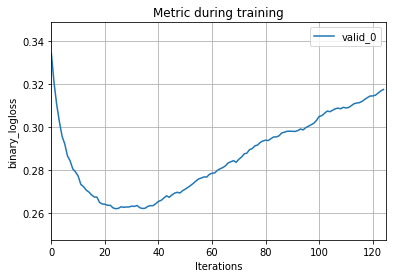

In [23]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()


Plotting feature importances...


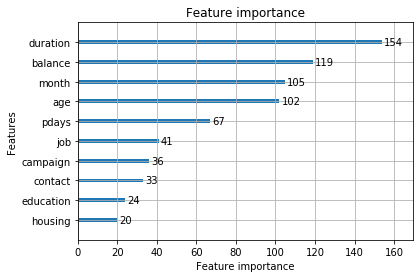

In [24]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, max_num_features=10)
plt.show()

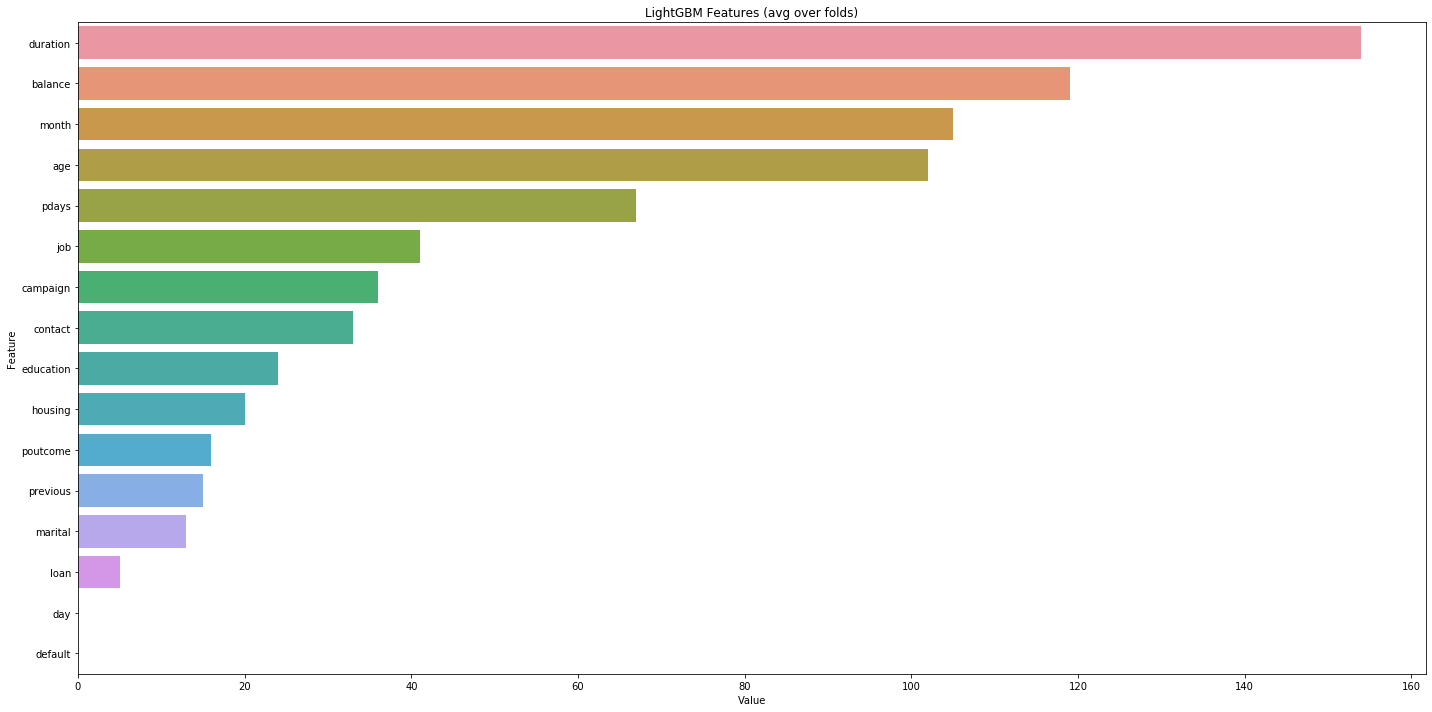

In [25]:
# more beautiful plot code

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

# AUC score using small part of training data for evaluation

In [26]:
predictions_probs = gbm.predict(X_test)
# keep probabilities for the positive outcome only
pos_probs = predictions_probs

In [27]:
import statistics
median_predict_value = statistics.median(pos_probs)

In [28]:
train['y'].value_counts()

0    4000
1     521
Name: y, dtype: int64

In [29]:
positive_ratio = 521/(4000+521)

In [30]:
threshold = positive_ratio # threshold we set where the probability prediction must be above this to be classified as a '1'
classes = predictions_probs.copy() # say it is the class in the second column you care about predictint
classes[classes>=threshold] = 1
classes[classes<threshold] = 0

In [31]:
uniqueValues, occurCount = np.unique(classes, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0. 1.]
Occurrence Count :  [847 284]


# AUC on probabilities

In [35]:
from sklearn import metrics

In [36]:
lgb_auc = metrics.roc_auc_score(y_test, pos_probs)

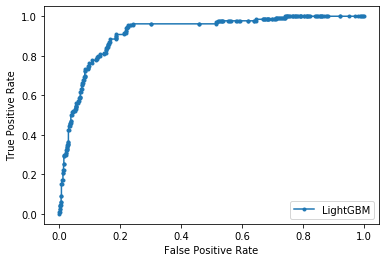

In [37]:
from matplotlib import pyplot
lgb_fpr, lgb_tpr, _ = metrics.roc_curve(y_test, pos_probs)
# plot the roc curve for the model
pyplot.plot(lgb_fpr, lgb_tpr, marker='.', label='LightGBM')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [38]:
lgb_auc

0.9143971413202182

# AUC on threshold = positive_ratio

In [39]:
lgb_auc = metrics.roc_auc_score(y_test, classes)

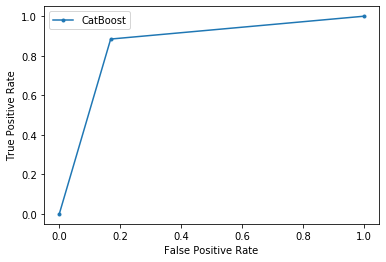

In [40]:
from matplotlib import pyplot
lgb_fpr, lgb_tpr, _ = metrics.roc_curve(y_test, classes)
# plot the roc curve for the model
pyplot.plot(lgb_fpr, lgb_tpr, marker='.', label='CatBoost')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [41]:
lgb_auc

0.8578921078921079

# Modeling using all training data to predict test data

In [42]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 500) 

In [43]:
X = train.drop(['y'], axis=1)
y = train[['y']]

In [44]:
from sklearn.model_selection import train_test_split

X_train_sub, X_val_sub, y_train_sub, y_val_sub = train_test_split(X, y, train_size=0.75, random_state=1337,stratify=y)


In [45]:
lgb_train = lgb.Dataset(X_train_sub, y_train_sub,
                        free_raw_data=False)
lgb_eval = lgb.Dataset(X_val_sub, y_val_sub, reference=lgb_train,
                        free_raw_data=False)

In [46]:
num_train, num_feature = X_train_sub.shape

In [47]:
# generate feature names
# feature_name = ['feature_' + str(col) for col in range(num_feature)]
feature_name = X_train_sub.columns.tolist()

In [48]:
categorical_features_indices = np.where(X.dtypes == "category")[0]

In [49]:
# specify your configurations as a dict
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'early_stopping_rounds' : 100,
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [50]:
evals_result = {}  # to record eval results for plotting

In [63]:
%%time
print('Starting training...')
# feature_name and categorical_feature
final_model = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,  # eval training data
                feature_name=feature_name,
                categorical_feature=categorical_features_indices.tolist(),
                evals_result=evals_result
               )

Starting training...
[1]	valid_0's binary_logloss: 0.34368
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.333426
[3]	valid_0's binary_logloss: 0.328988
[4]	valid_0's binary_logloss: 0.319788
[5]	valid_0's binary_logloss: 0.31243
[6]	valid_0's binary_logloss: 0.305554
[7]	valid_0's binary_logloss: 0.299377
[8]	valid_0's binary_logloss: 0.293522
[9]	valid_0's binary_logloss: 0.289118
[10]	valid_0's binary_logloss: 0.283187
[11]	valid_0's binary_logloss: 0.278904
[12]	valid_0's binary_logloss: 0.274074
[13]	valid_0's binary_logloss: 0.269942
[14]	valid_0's binary_logloss: 0.266031
[15]	valid_0's binary_logloss: 0.262249
[16]	valid_0's binary_logloss: 0.259024
[17]	valid_0's binary_logloss: 0.256394
[18]	valid_0's binary_logloss: 0.254328
[19]	valid_0's binary_logloss: 0.251794
[20]	valid_0's binary_logloss: 0.25018
[21]	valid_0's binary_logloss: 0.248313
[22]	valid_0's binary_logloss: 0.246884
[23]	valid_0's binary_logloss: 0.245103
[24]	vali

C:\Users\willy\anaconda3\lib\site-packages\lightgbm\engine.py:153: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[40]	valid_0's binary_logloss: 0.228257
[41]	valid_0's binary_logloss: 0.227549
[42]	valid_0's binary_logloss: 0.226943
[43]	valid_0's binary_logloss: 0.226681
[44]	valid_0's binary_logloss: 0.225953
[45]	valid_0's binary_logloss: 0.225254
[46]	valid_0's binary_logloss: 0.224252
[47]	valid_0's binary_logloss: 0.223978
[48]	valid_0's binary_logloss: 0.223437
[49]	valid_0's binary_logloss: 0.222892
[50]	valid_0's binary_logloss: 0.22229
[51]	valid_0's binary_logloss: 0.221632
[52]	valid_0's binary_logloss: 0.220896
[53]	valid_0's binary_logloss: 0.220527
[54]	valid_0's binary_logloss: 0.22047
[55]	valid_0's binary_logloss: 0.220237
[56]	valid_0's binary_logloss: 0.219813
[57]	valid_0's binary_logloss: 0.219616
[58]	valid_0's binary_logloss: 0.219446
[59]	valid_0's binary_logloss: 0.219055
[60]	valid_0's binary_logloss: 0.218602
[61]	valid_0's binary_logloss: 0.218559
[62]	valid_0's binary_logloss: 0.218411
[63]	valid_0's binary_logloss: 0.21803
[64]	valid_0's binary_logloss: 0.217742
[65

In [52]:
# feature names
print('Feature names:', final_model.feature_name())

# feature importances
print('Feature importances:', list(final_model.feature_importance()))

Feature names: ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome']
Feature importances: [435, 201, 66, 89, 6, 587, 83, 44, 112, 0, 347, 634, 172, 234, 75, 65]


feature importance plot

In [53]:
if lgb.compat.MATPLOTLIB_INSTALLED:
    import matplotlib.pyplot as plt
else:
    raise ImportError('You need to install matplotlib for plot_example.py.')

Plotting metrics recorded during training...


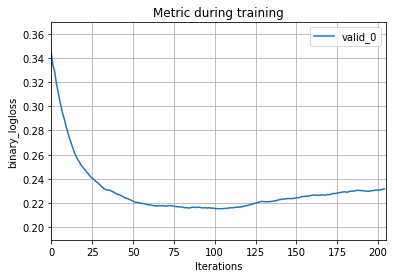

In [54]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result, metric='binary_logloss')
plt.show()


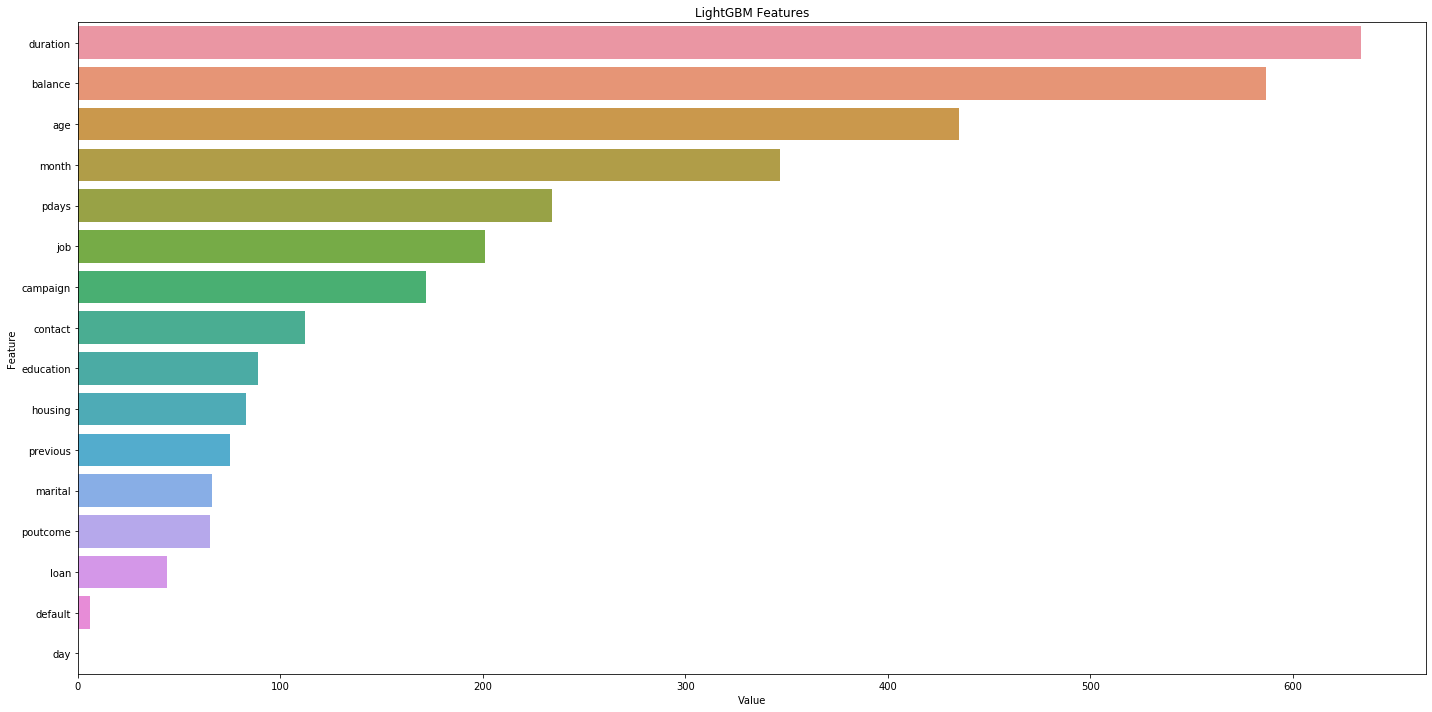

In [64]:
# more beautiful plot code

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(final_model.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features')
plt.tight_layout()
plt.show()
# plt.savefig('lgbm_importances-01.png')

# Test dataset for submission

In [56]:
X_test = test

In [57]:
predictions_probs = final_model.predict(X_test)
# keep probabilities for the positive outcome only
pos_probs = predictions_probs

In [58]:
import statistics
median_predict_value = statistics.median(pos_probs)

In [59]:
positive_ratio = 521/(4000+521)

In [60]:
threshold = positive_ratio # threshold we set where the probability prediction must be above this to be classified as a '1'
classes = predictions_probs.copy() # say it is the class in the second column you care about predictint
classes[classes>=threshold] = 1
classes[classes<threshold] = 0

In [61]:
uniqueValues, occurCount = np.unique(classes, return_counts=True)
 
print("Unique Values : " , uniqueValues)
print("Occurrence Count : ", occurCount)

Unique Values :  [0. 1.]
Occurrence Count :  [363  64]


In [62]:
pos_probs.shape

(427,)

# Submission file

In [159]:
resultdf = pd.DataFrame(columns=['Id', 'y'])

In [160]:
resultdf['Id'] = test_id
resultdf['y'] = classes # pos_probs for probabilities

In [161]:
resultdf.to_csv('./output/bank_marketing/submission(lgb auc 0.8578921078921079 on self test threshold=positive ratio).csv',index=False)

In [83]:
# submit on https://www.kaggle.com/c/bank-marketing-uci/submissions, public AUC = 0.81013, private AUC = 0.87091